## Feature Selection

### Select features and target

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("../data/processed/model_dataset.csv")

TARGET = "churn"

X = df.drop(columns=[TARGET])
y = df[TARGET]

### Identify feature types

In [2]:
# Identify feature types
categorical_cols = X.select_dtypes(include = ["object"]).columns.tolist()
numerical_cols = X.select_dtypes(include=["int64","float64"]).columns.tolist()

print("Categorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols) 

Categorical columns: ['signup_date', 'province', 'segment', 'acquisition_channel', 'plan_type', 'contract_type', 'status']
Numerical columns: ['customer_id', 'age', 'price_per_month', 'churn_date', 'login_count_mean', 'login_count_std', 'login_count_last', 'active_days_mean', 'active_days_std', 'total_usage_hours_mean', 'total_usage_hours_std', 'total_usage_hours_last', 'num_features_used_mean', 'heavy_feature_usage_mean', 'num_sessions_mobile_mean', 'num_sessions_web_mean', 'days_late_mean', 'days_late_max', 'failed_payment_sum', 'amount_paid_mean', 'ticket_count', 'avg_satisfaction_score', 'avg_resolution_time_hours', 'cancelled', 'no_usage_2mo', 'failed_payments_3mo']


### Train test split

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42,
                                                  stratify=y)

### Preprocessing Pipeline

In [4]:
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [5]:
# Numeric pipeline
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]
)

# Categorical pipeline
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]
)

# Combine
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

### Defining the Baseline Model: Logistic Regression(Class weighted)

In [6]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42)
log_reg_pipeline = Pipeline(steps=[("preprocessor", preprocessor),("model",log_reg)])

## Train the Baseline Model

In [80]:
log_reg_pipeline.fit(X_train,y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [81]:
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    confusion_matrix,
    RocCurveDisplay
)

y_pred_proba = log_reg_pipeline.predict_proba(X_test)[:, 1]
y_pred = log_reg_pipeline.predict(X_test)

roc_auc = roc_auc_score(y_test, y_pred_proba)
roc_auc


0.9030181086519113

### Checks to investigate where data leakage is coming from

In [82]:
"churn" in X.columns

False

In [83]:
for col in X.columns:
    if X[col].nunique() <= 5:
        print(col)

segment
acquisition_channel
plan_type
contract_type
price_per_month


In [84]:
pd.crosstab(df[col],df['churn'],normalize='index')

churn,0,1
avg_resolution_time_hours,,
0.006910,1.0,0.0
0.008374,1.0,0.0
0.009690,1.0,0.0
0.011104,1.0,0.0
0.031080,1.0,0.0
...,...,...
159.417971,1.0,0.0
162.144804,1.0,0.0
169.637777,1.0,0.0


In [85]:
import numpy as np

y_test_shuffled = np.random.permutation(y_test)

roc_auc_score(y_test_shuffled, y_pred_proba)


0.3530516431924883

### Fix data leakage

In [86]:
LEAKY_COLS = ["churn_date",
    "cancelled",
    "status",
    "no_usage_2mo",
    "failed_payments_3mo"]

X = df.drop(columns = ["churn"] + LEAKY_COLS)
y = df["churn"]

In [87]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42,
                                                  stratify=y)

In [88]:
# log_reg_pipeline.fit(X_train,y_train)
# y_pred_proba = log_reg_pipeline.predict_proba(X_test)[:,1]
# roc_auc_score(y_test, y_pred_proba)

In [89]:
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

print("Categorical columns:", categorical_cols)
print("Numeric columns:", numerical_cols)


Categorical columns: ['signup_date', 'province', 'segment', 'acquisition_channel', 'plan_type', 'contract_type']
Numeric columns: ['customer_id', 'age', 'price_per_month', 'login_count_mean', 'login_count_std', 'login_count_last', 'active_days_mean', 'active_days_std', 'total_usage_hours_mean', 'total_usage_hours_std', 'total_usage_hours_last', 'num_features_used_mean', 'heavy_feature_usage_mean', 'num_sessions_mobile_mean', 'num_sessions_web_mean', 'days_late_mean', 'days_late_max', 'failed_payment_sum', 'amount_paid_mean', 'ticket_count', 'avg_satisfaction_score', 'avg_resolution_time_hours']


In [90]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# Numeric pipeline
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]
)

# Categorical pipeline
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]
)

# Combine
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

In [91]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(
    class_weight="balanced",
    max_iter=1000,
    random_state=42
)

log_reg_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", log_reg)
    ]
)


In [92]:
# Identify feature types
categorical_cols = X.select_dtypes(include = ["object"]).columns.tolist()
numerical_cols = X.select_dtypes(include=["int64","float64"]).columns.tolist()

print("Categorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols) 

Categorical columns: ['signup_date', 'province', 'segment', 'acquisition_channel', 'plan_type', 'contract_type']
Numerical columns: ['customer_id', 'age', 'price_per_month', 'login_count_mean', 'login_count_std', 'login_count_last', 'active_days_mean', 'active_days_std', 'total_usage_hours_mean', 'total_usage_hours_std', 'total_usage_hours_last', 'num_features_used_mean', 'heavy_feature_usage_mean', 'num_sessions_mobile_mean', 'num_sessions_web_mean', 'days_late_mean', 'days_late_max', 'failed_payment_sum', 'amount_paid_mean', 'ticket_count', 'avg_satisfaction_score', 'avg_resolution_time_hours']


In [93]:
log_reg_pipeline.fit(X_train, y_train)

y_pred_proba = log_reg_pipeline.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred_proba)


0.9030181086519113

### Evaluation (Confusion Matrix)

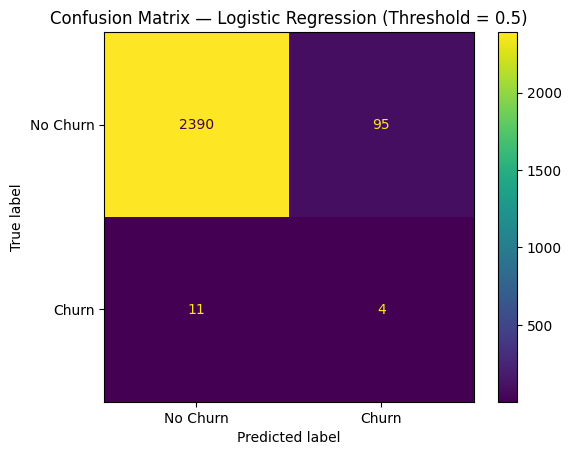

In [94]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["No Churn", "Churn"]
)

disp.plot(cmap="viridis", values_format="d")
plt.title("Confusion Matrix — Logistic Regression (Threshold = 0.5)")
plt.show()


### Threshold tuning

In [95]:
threshold  = 0.25
y_pred_adj = (y_pred_proba >= threshold).astype(int)

confusion_matrix(y_test, y_pred_adj)

array([[2295,  190],
       [   6,    9]])

## Testing XGBoost tree based model

In [23]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [24]:
from xgboost import XGBClassifier

In [25]:
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
scale_pos_weight


np.float64(158.5744680851064)

### Defining the XGBOOST Model

In [26]:
xgb_model = XGBClassifier(
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    eval_metric="auc",
    random_state=42,
    n_jobs=-1
)


### Build the pipeline

In [27]:
xgb_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", xgb_model)
    ]
)


### Train the Model

In [28]:
xgb_pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [29]:
y_pred_proba_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
roc_auc_xgb


0.8323272971160296

### Tuning XGBOOST Configuration

In [30]:
from xgboost import XGBClassifier

xgb_model_tuned = XGBClassifier(
    n_estimators=600,
    max_depth=3,              
    learning_rate=0.03,       
    subsample=0.9,
    colsample_bytree=0.9,
    min_child_weight=10,      
    gamma=1,                  
    max_delta_step=1,         
    scale_pos_weight=scale_pos_weight,
    eval_metric="auc",
    random_state=42,
    n_jobs=-1
)


In [31]:
xgb_pipeline_tuned = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", xgb_model_tuned)
    ]
)


In [32]:
xgb_pipeline_tuned.fit(X_train, y_train)


,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [33]:
y_pred_proba_xgb_tuned = xgb_pipeline_tuned.predict_proba(X_test)[:, 1]

roc_auc_xgb_tuned = roc_auc_score(y_test, y_pred_proba_xgb_tuned)
roc_auc_xgb_tuned


0.8831656606304493

In [34]:
threshold = 0.25
y_pred_adj_xgb = (y_pred_proba_xgb_tuned >= threshold).astype(int)

confusion_matrix(y_test, y_pred_adj_xgb)


array([[2300,  185],
       [   8,    7]])

## SHAP Exxplainability

In [57]:
pip install shap


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [58]:
import shap

### Extract Trained model  & data

In [59]:
# Extract trained components
preprocessor_fitted = log_reg_pipeline.named_steps["preprocessor"]
model_fitted = log_reg_pipeline.named_steps["model"]

# Transform training data
X_train_transformed = preprocessor_fitted.transform(X_train)


### Create  SHAP explainer

In [60]:
explainer = shap.LinearExplainer(
    model_fitted,
    X_train_transformed,
    feature_perturbation="interventional"
)

shap_values = explainer.shap_values(X_train_transformed)


c:\Users\akink\My Repos\Customer Churn Prediction\Customer-Churn-Prediction-with-Explainability-and-Segmentation\venv\lib\site-packages\shap\explainers\_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


### Get the feature names

In [61]:
feature_names = (
    numerical_cols +
    list(
        preprocessor_fitted
        .named_transformers_["cat"]
        .named_steps["encoder"]
        .get_feature_names_out(categorical_cols)
    )
)


### Get Global feature importance

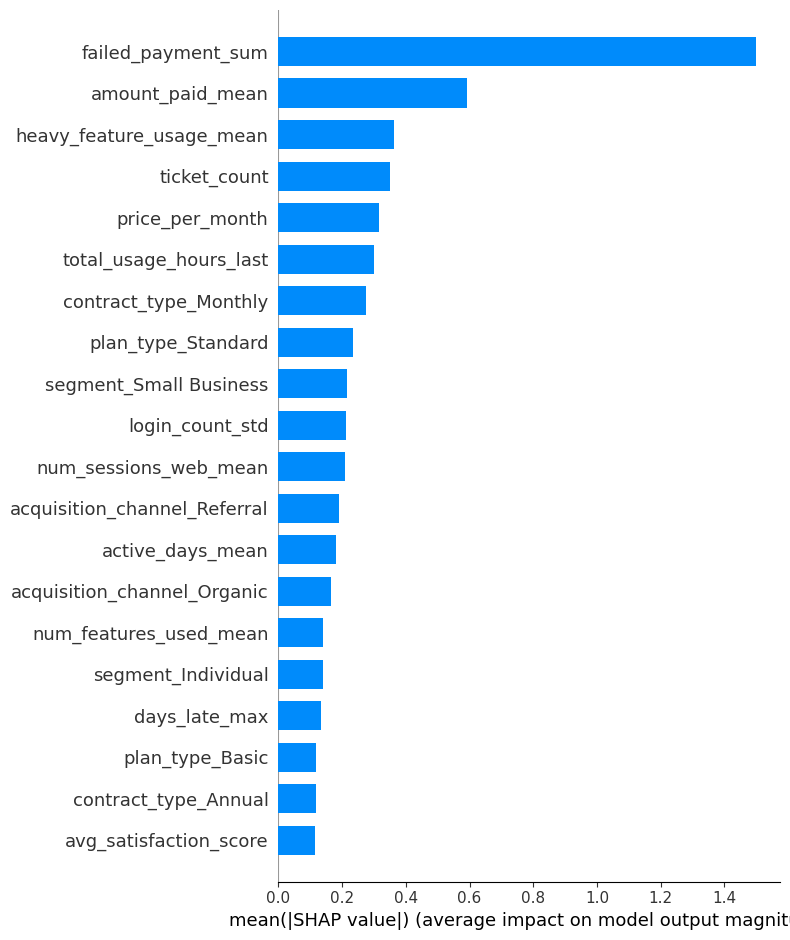

In [62]:
shap.summary_plot(
    shap_values,
    X_train_transformed,
    feature_names=feature_names,
    plot_type="bar"
)


### Detailed impact plot

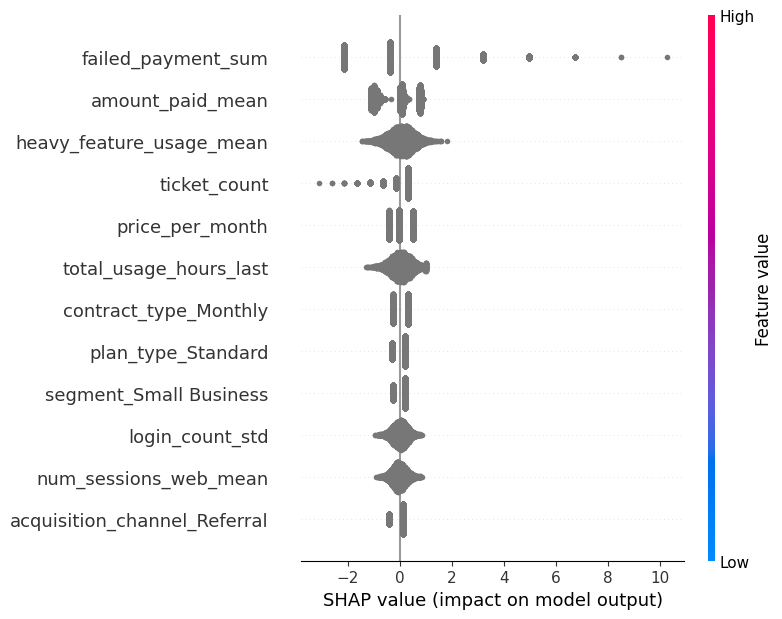

In [74]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
shap.summary_plot(
    shap_values,
    X_train_transformed,
    feature_names=feature_names,
    max_display=12,
    show=False
)
plt.tight_layout()
plt.show()



### Individual Customer explanation

In [65]:
customer_idx = 10

X_customer_dense = X_train_transformed[customer_idx].toarray()[0]


In [66]:
explainer.expected_value


np.float64(-4.903361993886935)

In [67]:
expected_value = explainer.expected_value
if isinstance(expected_value, (list, np.ndarray)):
    expected_value = expected_value[0]


In [70]:
import shap
import numpy as np

customer_idx = 10

shap_exp = shap.Explanation(
    values=shap_values[customer_idx],
    base_values=expected_value,
    data=X_customer_dense,
    feature_names=feature_names
)


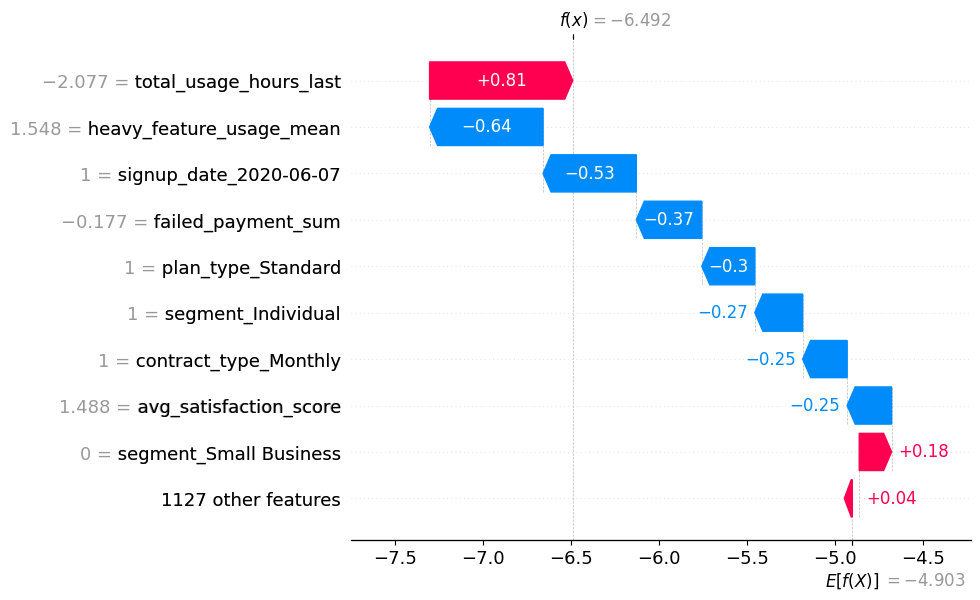

In [71]:
shap.plots.waterfall(
    shap_exp,
    max_display=10  # show only top 10 drivers
)


In [72]:
grouped_features = {
    "Usage Behavior": ["total_usage_hours_last", "heavy_feature_usage"],
    "Payment Risk": ["failed_payment_sum"],
    "Contract": ["contract_type_monthly"],
    "Customer Value": ["price_per_month"],
}


In [69]:
len(feature_names), X_customer_dense.shape, shap_values[customer_idx].shape


(1136, (1136,), (1136,))

## SEGMENTED SHAP ANALYSIS

### Identify Segment columns in transformed data

In [98]:
segment_individual_idx = feature_names.index("segment_Individual")
segment_smb_idx = feature_names.index("segment_Small Business")


### Split Customers by Segment (on transformed data)

In [99]:
import numpy as np

# Boolean masks
individual_mask = X_train_transformed[:, segment_individual_idx].toarray().ravel() == 1
smb_mask = X_train_transformed[:, segment_smb_idx].toarray().ravel() == 1

# Segment-specific SHAP values
shap_individual = shap_values[individual_mask]
shap_smb = shap_values[smb_mask]

# Segment-specific feature data
X_individual = X_train_transformed[individual_mask]
X_smb = X_train_transformed[smb_mask]


### SHAP summary for individual customers

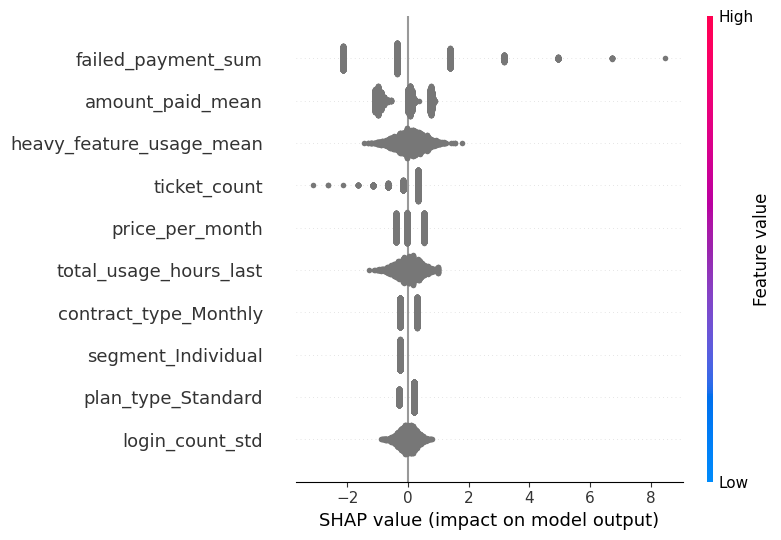

In [100]:
shap.summary_plot(
    shap_individual,
    X_individual,
    feature_names=feature_names,
    max_display=10
)


### SHAP summary for small business customers

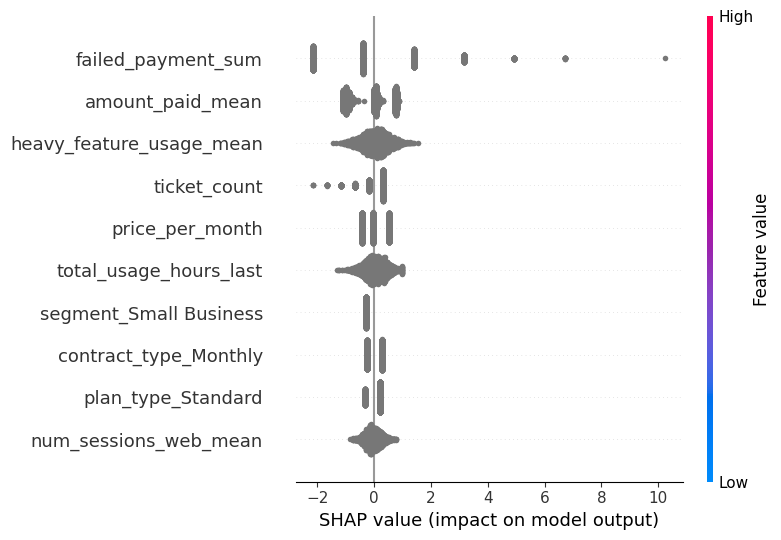

In [101]:
shap.summary_plot(
    shap_smb,
    X_smb,
    feature_names=feature_names,
    max_display=10
)


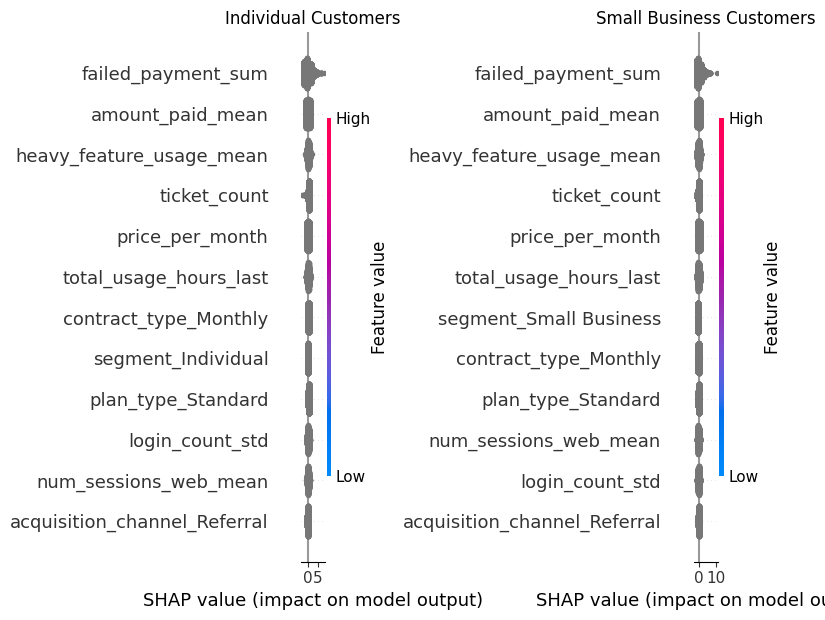

In [103]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
shap.summary_plot(shap_individual, X_individual, feature_names=feature_names, max_display=12, show=False)
plt.title("Individual Customers")

plt.subplot(1,2,2)
shap.summary_plot(shap_smb, X_smb, feature_names=feature_names, max_display=12, show=False)
plt.title("Small Business Customers")

plt.tight_layout()
plt.show()


In [ ]:
import joblib

)


FileNotFoundError: [Errno 2] No such file or directory: 'models/log_reg_pipeline.pkl'